In [1]:
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

from keras.models import Sequential, load_model
from keras.layers.core import Dropout, Activation, Flatten, Reshape
from keras.utils import np_utils
from keras.layers import Convolution2D as Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.datasets import mnist
from keras.layers import Input, Dense, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
import os
import pickle
import math

In [6]:
features_folder = "C:\\Users\\t-anmend\\Documents\\train_1\\"

In [3]:
features_folder = "/home/t-anmend/train1"

In [4]:
with open(os.path.join(features_folder,'train1_features.txt'),'rb') as f:
    features  = pickle.load(f)

In [50]:
with open(os.path.join(features_folder,'train1_stats_features.txt'),'rb') as f:
    features_stats  = pickle.load(f)

In [5]:
features[0]

[array([[153,   8, 164, ...,   0,   5, 255],
        [154,  10, 163, ...,   0,  39, 255],
        [153,   7, 164, ...,   0,   9, 255],
        ...,
        [165,  43, 168, ..., 155, 177, 255],
        [162,  39, 188, ..., 107, 200, 255],
        [164,  38, 176, ..., 209, 153, 255]], dtype=uint8),
 ['drilling', 'dog_bark', 'air_conditioner', 'children_playing', 'jackhammer'],
 'C:\\Users\\t-anmend\\Documents\\train_1\\uniform\\soundscape_train_1_uniform0.wav']

# Features 19x128

In [6]:
np.random.seed(123)

In [7]:
index_features = np.arange(len(features))
    
train_ind = np.random.choice(index_features, int(0.7 * len(index_features)), replace=False)

In [8]:
len(train_ind)

2100

In [9]:
X_train = []
y_train = []
X_test = []
y_test = []

for index in range(len(features)):
    if index in train_ind:
        X_train.append(features[index][0])
        y_train.append(features[index][1])
    else:
        X_test.append(features[index][0])
        y_test.append(features[index][1])

In [10]:
len(X_train)

2100

In [11]:
len(y_train)

2100

In [12]:
len(X_test)

900

In [13]:
len(y_test)

900

In [14]:
X_train = np.array(X_train)

In [15]:
X_test = np.array(X_test)

In [16]:
X_train.shape

(2100, 19, 128)

In [17]:
X_test.shape

(900, 19, 128)

In [143]:
num_zeros = (2**(math.ceil(math.log(X_train.shape[1], 2))) - X_train.shape[1])

In [144]:
num_zeros

13

In [145]:
num_zeros_up = int(np.ceil(num_zeros / 2))

In [146]:
num_zeros_down = num_zeros - num_zeros_up

In [147]:
num_zeros_up

7

In [148]:
num_zeros_down

6

In [149]:
X_train_padded = np.zeros((X_train.shape[0], X_train.shape[1] + num_zeros, X_train.shape[2]))

for i in range(X_train.shape[0]):
    X_train_padded[i] = np.vstack((np.zeros((num_zeros_up, X_train.shape[2])), X_train[i], np.zeros((num_zeros_down, X_train.shape[2]))))

In [150]:
X_test_padded = np.zeros((X_test.shape[0], X_test.shape[1] + num_zeros, X_test.shape[2]))
for i in range(X_test.shape[0]):
    X_test_padded[i] = np.vstack((np.zeros((num_zeros_up, X_test.shape[2])), X_test[i], np.zeros((num_zeros_down, X_train.shape[2]))))

In [151]:
X_train_padded.shape

(2100, 32, 128)

In [26]:
X_test_padded.shape

(900, 32, 128)

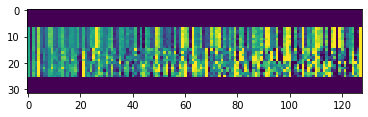

In [27]:
from matplotlib import pyplot as plt
plt.imshow(X_train_padded[0])

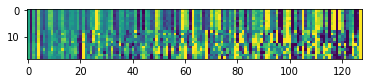

In [18]:
from matplotlib import pyplot as plt
plt.imshow(X_train[0])

# Features reshaped

In [51]:
np.random.seed(123)

In [52]:
index_features = np.arange(len(features))
    
train_ind = np.random.choice(index_features, int(0.7 * len(index_features)), replace=False)

In [53]:
len(train_ind)

2100

In [54]:
X_train = []
y_train = []
X_test = []
y_test = []

for index in range(len(features)):
    if index in train_ind:
        X_train.append(features[index][0])
        y_train.append(features[index][1])
    else:
        X_test.append(features[index][0])
        y_test.append(features[index][1])

In [55]:
len(X_train)

2100

In [56]:
len(y_train)

2100

In [57]:
len(X_test)

900

In [58]:
len(y_test)

900

In [59]:
X_train = np.array(X_train)

In [60]:
X_test = np.array(X_test)

In [61]:
X_train.shape

(2100, 19, 128)

In [62]:
X_test.shape

(900, 19, 128)

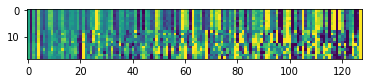

In [64]:
from matplotlib import pyplot as plt
plt.imshow(X_train[0])

# Build the neural network model

In [19]:
encoding_dim = 1000  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
#input_img = Input(shape=(np.prod(X_train.shape[1:]),))
input_img = Input(shape=(19,128,1))
# "encoded" is the encoded representation of the input
x = (Flatten(name='flatten'))(input_img)
x = Dense(np.prod(X_train.shape[1:]), activation='relu')(x)
x = Dense(encoding_dim, activation='relu')(x)
#x = Dense(512, activation='relu')(x)

#encoded = Dense(256, activation='relu')(x)

# "decoded" is the lossy reconstruction of the input
encoded = Dense(512, activation='relu')(x)
x = Dense(1000, activation='relu')(encoded)

x = Dense(np.prod(X_train.shape[1:]), activation='relu')(x)
decoded = (Reshape((19,128,1)))(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

W0722 15:14:11.888473 140518029633280 deprecation_wrapper.py:119] From /home/t-anmend/anaconda3/envs/clustering/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 15:14:11.917692 140518029633280 deprecation_wrapper.py:119] From /home/t-anmend/anaconda3/envs/clustering/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 15:14:11.928736 140518029633280 deprecation_wrapper.py:119] From /home/t-anmend/anaconda3/envs/clustering/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [66]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [67]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(256,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [20]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

W0722 15:14:33.905975 140518029633280 deprecation_wrapper.py:119] From /home/t-anmend/anaconda3/envs/clustering/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [69]:
X_train = X_train.reshape((X_train.shape[0],np.prod(X_train.shape[1:])))
X_test = X_test.reshape((X_test.shape[0], np.prod(X_test.shape[1:])))
print(X_train.shape)
print(X_test.shape)

(2100, 2432)
(900, 2432)


In [ ]:
X_train.min(axis=0).min()

In [ ]:
X_train[0]

In [70]:
X_train = (X_train) / 255
X_test = (X_test) / 255

print(X_train.shape)
print(X_test.shape)

(2100, 2432)
(900, 2432)


In [ ]:
X_train = (X_train - X_train.mean(axis=0)) / (X_train.max(axis=0) - X_train.min(axis=0) + 1e-6)
X_test = (X_test - X_test.mean(axis=0)) / (X_test.max(axis=0) - X_test.min(axis=0) + 1e-6)

print(X_train.shape)
print(X_test.shape)

In [ ]:
X_train[0]

In [ ]:
X_test[0]

In [25]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))

In [26]:
X_train.shape

(2100, 19, 128, 1)

In [27]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

In [28]:
X_test.shape

(900, 19, 128, 1)

In [21]:
import time
from datetime import datetime


In [41]:
today = datetime.today()

t = today.strftime("%Y%m%d_%H%M%S")

model_folder = f"C:\\Users\\t-anmend\\Documents\\train_1\\models\\best_model_CNN_{t}.ckpt"
model_folder

'C:\\Users\\t-anmend\\Documents\\train_1\\models\\best_model_CNN_20190718_133049.ckpt'

In [22]:
today = datetime.today()

t = today.strftime("%Y%m%d_%H%M%S")

model_folder = f"/home/t-anmend/train1/models/best_model_CNN_{t}.ckpt"
model_folder

'/home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt'

In [23]:
checkpoint = ModelCheckpoint(model_folder, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [24]:
tensorboard = TensorBoard(log_dir=f"/home/t-anmend/train1/tensor_board/{t}")

In [29]:
rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-7)

In [30]:
autoencoder.fit(X_train, X_train,
                epochs=3000,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[checkpoint, tensorboard,rate])

W0722 15:16:25.439339 140518029633280 deprecation_wrapper.py:119] From /home/t-anmend/anaconda3/envs/clustering/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0722 15:16:25.570036 140518029633280 deprecation_wrapper.py:119] From /home/t-anmend/anaconda3/envs/clustering/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 2100 samples, validate on 900 samples


W0722 15:16:28.589735 140518029633280 deprecation_wrapper.py:119] From /home/t-anmend/anaconda3/envs/clustering/lib/python3.7/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0722 15:16:28.594825 140518029633280 deprecation_wrapper.py:119] From /home/t-anmend/anaconda3/envs/clustering/lib/python3.7/site-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/3000
2100/2100 [==============================] - 2s 855us/step - loss: 72519.0307 - val_loss: 8567.1358

Epoch 00001: val_loss improved from inf to 8567.13580, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 2/3000
2100/2100 [==============================] - 2s 730us/step - loss: 7772.7871 - val_loss: 6515.7006

Epoch 00002: val_loss improved from 8567.13580 to 6515.70056, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 3/3000
2100/2100 [==============================] - 1s 427us/step - loss: 6182.2602 - val_loss: 5880.3561

Epoch 00003: val_loss improved from 6515.70056 to 5880.35609, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 4/3000
2100/2100 [==============================] - 2s 764us/step - loss: 5762.9578 - val_loss: 5661.3367

Epoch 00004: val_loss improved from 5880.35609 to 5661.33674, saving model to /home/t-anmend/train1/models/best_model_CNN_201

Epoch 33/3000
2100/2100 [==============================] - 1s 474us/step - loss: 4136.5440 - val_loss: 4118.4368

Epoch 00033: val_loss improved from 4172.32495 to 4118.43680, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 34/3000
2100/2100 [==============================] - 1s 500us/step - loss: 4107.1944 - val_loss: 4109.6512

Epoch 00034: val_loss improved from 4118.43680 to 4109.65117, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 35/3000
2100/2100 [==============================] - 1s 568us/step - loss: 4081.2163 - val_loss: 4065.7883

Epoch 00035: val_loss improved from 4109.65117 to 4065.78834, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 36/3000
2100/2100 [==============================] - 1s 640us/step - loss: 4030.3031 - val_loss: 4016.9480

Epoch 00036: val_loss improved from 4065.78834 to 4016.94797, saving model to /home/t-anmend/train1/models/best_mod

Epoch 65/3000
2100/2100 [==============================] - 1s 437us/step - loss: 3237.2533 - val_loss: 3314.7878

Epoch 00065: val_loss improved from 3323.94430 to 3314.78775, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 66/3000
2100/2100 [==============================] - 1s 696us/step - loss: 3217.7404 - val_loss: 3298.3035

Epoch 00066: val_loss improved from 3314.78775 to 3298.30350, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 67/3000
2100/2100 [==============================] - 1s 591us/step - loss: 3207.5090 - val_loss: 3291.8348

Epoch 00067: val_loss improved from 3298.30350 to 3291.83483, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 68/3000
2100/2100 [==============================] - 1s 574us/step - loss: 3195.7801 - val_loss: 3281.2352

Epoch 00068: val_loss improved from 3291.83483 to 3281.23522, saving model to /home/t-anmend/train1/models/best_mod

Epoch 99/3000
2100/2100 [==============================] - 1s 521us/step - loss: 2752.9676 - val_loss: 2930.2905

Epoch 00099: val_loss did not improve from 2925.14728
Epoch 100/3000
2100/2100 [==============================] - 1s 632us/step - loss: 2744.1657 - val_loss: 2919.3694

Epoch 00100: val_loss improved from 2925.14728 to 2919.36940, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 101/3000
2100/2100 [==============================] - 1s 593us/step - loss: 2746.8628 - val_loss: 2913.2812

Epoch 00101: val_loss improved from 2919.36940 to 2913.28124, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 102/3000
2100/2100 [==============================] - 1s 551us/step - loss: 2731.8739 - val_loss: 2906.2583

Epoch 00102: val_loss improved from 2913.28124 to 2906.25834, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 103/3000
2100/2100 [==============================] 

Epoch 135/3000
2100/2100 [==============================] - 1s 511us/step - loss: 2471.2461 - val_loss: 2740.6630

Epoch 00135: val_loss did not improve from 2735.84683
Epoch 136/3000
2100/2100 [==============================] - 1s 634us/step - loss: 2468.0815 - val_loss: 2728.5691

Epoch 00136: val_loss improved from 2735.84683 to 2728.56908, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 137/3000
2100/2100 [==============================] - 1s 582us/step - loss: 2462.5733 - val_loss: 2739.0213

Epoch 00137: val_loss did not improve from 2728.56908
Epoch 138/3000
2100/2100 [==============================] - 1s 601us/step - loss: 2458.1934 - val_loss: 2736.5806

Epoch 00138: val_loss did not improve from 2728.56908
Epoch 139/3000
2100/2100 [==============================] - 2s 715us/step - loss: 2470.2704 - val_loss: 2720.5128

Epoch 00139: val_loss improved from 2728.56908 to 2720.51282, saving model to /home/t-anmend/train1/models/best_model_CN


Epoch 00174: val_loss did not improve from 2655.68907
Epoch 175/3000
2100/2100 [==============================] - 1s 708us/step - loss: 2297.4210 - val_loss: 2667.4474

Epoch 00175: val_loss did not improve from 2655.68907
Epoch 176/3000
2100/2100 [==============================] - 1s 457us/step - loss: 2303.4984 - val_loss: 2683.8023

Epoch 00176: val_loss did not improve from 2655.68907
Epoch 177/3000
2100/2100 [==============================] - 1s 680us/step - loss: 2313.8559 - val_loss: 2655.5784

Epoch 00177: val_loss improved from 2655.68907 to 2655.57844, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 178/3000
2100/2100 [==============================] - 1s 449us/step - loss: 2287.6741 - val_loss: 2653.9752

Epoch 00178: val_loss improved from 2655.57844 to 2653.97515, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 179/3000
2100/2100 [==============================] - 1s 462us/step - loss: 2279.3652

Epoch 216/3000
2100/2100 [==============================] - 1s 447us/step - loss: 2134.1375 - val_loss: 2587.7808

Epoch 00216: val_loss did not improve from 2584.24482
Epoch 217/3000
2100/2100 [==============================] - 1s 701us/step - loss: 2131.9580 - val_loss: 2593.3962

Epoch 00217: val_loss did not improve from 2584.24482
Epoch 218/3000
2100/2100 [==============================] - 1s 692us/step - loss: 2132.3424 - val_loss: 2588.3430

Epoch 00218: val_loss did not improve from 2584.24482
Epoch 219/3000
2100/2100 [==============================] - 1s 443us/step - loss: 2132.1647 - val_loss: 2595.3565

Epoch 00219: val_loss did not improve from 2584.24482
Epoch 220/3000
2100/2100 [==============================] - 2s 719us/step - loss: 2133.7283 - val_loss: 2589.0445

Epoch 00220: val_loss did not improve from 2584.24482
Epoch 221/3000
2100/2100 [==============================] - 1s 431us/step - loss: 2120.2973 - val_loss: 2586.3151

Epoch 00221: val_loss did not improve fr


Epoch 00255: val_loss improved from 2553.32902 to 2553.27463, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 256/3000
2100/2100 [==============================] - 2s 714us/step - loss: 2061.3895 - val_loss: 2553.3435

Epoch 00256: val_loss did not improve from 2553.27463
Epoch 257/3000
2100/2100 [==============================] - 1s 696us/step - loss: 2061.0811 - val_loss: 2553.3552

Epoch 00257: val_loss did not improve from 2553.27463
Epoch 258/3000
2100/2100 [==============================] - 1s 590us/step - loss: 2060.8049 - val_loss: 2553.2288

Epoch 00258: val_loss improved from 2553.27463 to 2553.22876, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 259/3000
2100/2100 [==============================] - 1s 714us/step - loss: 2060.3819 - val_loss: 2553.3602

Epoch 00259: val_loss did not improve from 2553.22876
Epoch 260/3000
2100/2100 [==============================] - 1s 632us/step - loss: 2060.0542

2100/2100 [==============================] - 1s 622us/step - loss: 2046.3554 - val_loss: 2551.1581

Epoch 00297: val_loss did not improve from 2550.79429
Epoch 298/3000
2100/2100 [==============================] - 1s 518us/step - loss: 2045.9887 - val_loss: 2551.4235

Epoch 00298: val_loss did not improve from 2550.79429
Epoch 299/3000
2100/2100 [==============================] - 1s 611us/step - loss: 2045.5458 - val_loss: 2551.3962

Epoch 00299: val_loss did not improve from 2550.79429
Epoch 300/3000
2100/2100 [==============================] - 1s 535us/step - loss: 2045.1513 - val_loss: 2550.9713

Epoch 00300: val_loss did not improve from 2550.79429
Epoch 301/3000
2100/2100 [==============================] - 1s 613us/step - loss: 2044.8054 - val_loss: 2551.0372

Epoch 00301: val_loss did not improve from 2550.79429
Epoch 302/3000
2100/2100 [==============================] - 1s 549us/step - loss: 2044.2885 - val_loss: 2550.7095

Epoch 00302: val_loss improved from 2550.79429 to 2550.

Epoch 340/3000
2100/2100 [==============================] - 1s 655us/step - loss: 2029.5803 - val_loss: 2549.1053

Epoch 00340: val_loss did not improve from 2548.91241
Epoch 341/3000
2100/2100 [==============================] - 1s 511us/step - loss: 2029.1566 - val_loss: 2549.4482

Epoch 00341: val_loss did not improve from 2548.91241
Epoch 342/3000
2100/2100 [==============================] - 1s 637us/step - loss: 2028.7078 - val_loss: 2549.0333

Epoch 00342: val_loss did not improve from 2548.91241
Epoch 343/3000
2100/2100 [==============================] - 1s 470us/step - loss: 2028.3767 - val_loss: 2549.1473

Epoch 00343: val_loss did not improve from 2548.91241
Epoch 344/3000
2100/2100 [==============================] - 2s 730us/step - loss: 2028.0120 - val_loss: 2548.6599

Epoch 00344: val_loss improved from 2548.91241 to 2548.65986, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 345/3000
2100/2100 [==============================] - 2s 716

2100/2100 [==============================] - 1s 706us/step - loss: 2011.7684 - val_loss: 2546.1435

Epoch 00383: val_loss did not improve from 2545.77823
Epoch 384/3000
2100/2100 [==============================] - 2s 721us/step - loss: 2011.3073 - val_loss: 2546.9961

Epoch 00384: val_loss did not improve from 2545.77823
Epoch 385/3000
2100/2100 [==============================] - 1s 611us/step - loss: 2010.7730 - val_loss: 2546.1036

Epoch 00385: val_loss did not improve from 2545.77823
Epoch 386/3000
2100/2100 [==============================] - 1s 569us/step - loss: 2010.4384 - val_loss: 2546.7794

Epoch 00386: val_loss did not improve from 2545.77823
Epoch 387/3000
2100/2100 [==============================] - 2s 719us/step - loss: 2009.8964 - val_loss: 2546.4935

Epoch 00387: val_loss did not improve from 2545.77823
Epoch 388/3000
2100/2100 [==============================] - 1s 572us/step - loss: 2009.4503 - val_loss: 2546.0480

Epoch 00388: val_loss did not improve from 2545.77823
E

2100/2100 [==============================] - 1s 714us/step - loss: 2003.3411 - val_loss: 2544.6717

Epoch 00426: val_loss improved from 2544.71229 to 2544.67168, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 427/3000
2100/2100 [==============================] - 1s 707us/step - loss: 2003.3025 - val_loss: 2544.6750

Epoch 00427: val_loss did not improve from 2544.67168
Epoch 428/3000
2100/2100 [==============================] - 1s 574us/step - loss: 2003.2414 - val_loss: 2544.7145

Epoch 00428: val_loss did not improve from 2544.67168
Epoch 429/3000
2100/2100 [==============================] - 1s 584us/step - loss: 2003.1947 - val_loss: 2544.6742

Epoch 00429: val_loss did not improve from 2544.67168
Epoch 430/3000
2100/2100 [==============================] - 1s 708us/step - loss: 2003.1486 - val_loss: 2544.6972

Epoch 00430: val_loss did not improve from 2544.67168
Epoch 431/3000
2100/2100 [==============================] - 1s 546us/step - loss:

2100/2100 [==============================] - 2s 745us/step - loss: 2001.6780 - val_loss: 2544.5345

Epoch 00470: val_loss did not improve from 2544.50255
Epoch 471/3000
2100/2100 [==============================] - 2s 726us/step - loss: 2001.6713 - val_loss: 2544.5272

Epoch 00471: val_loss did not improve from 2544.50255

Epoch 00471: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 472/3000
2100/2100 [==============================] - 1s 624us/step - loss: 2001.6514 - val_loss: 2544.5277

Epoch 00472: val_loss did not improve from 2544.50255
Epoch 473/3000
2100/2100 [==============================] - 1s 502us/step - loss: 2001.6504 - val_loss: 2544.5299

Epoch 00473: val_loss did not improve from 2544.50255
Epoch 474/3000
2100/2100 [==============================] - 1s 707us/step - loss: 2001.6496 - val_loss: 2544.5311

Epoch 00474: val_loss did not improve from 2544.50255
Epoch 475/3000
2100/2100 [==============================] - 2s 747us/step - loss: 2001.6


Epoch 00516: val_loss did not improve from 2544.50255
Epoch 517/3000
2100/2100 [==============================] - 1s 696us/step - loss: 2001.6168 - val_loss: 2544.5160

Epoch 00517: val_loss did not improve from 2544.50255
Epoch 518/3000
2100/2100 [==============================] - 2s 744us/step - loss: 2001.6159 - val_loss: 2544.5170

Epoch 00518: val_loss did not improve from 2544.50255
Epoch 519/3000
2100/2100 [==============================] - 2s 720us/step - loss: 2001.6152 - val_loss: 2544.5187

Epoch 00519: val_loss did not improve from 2544.50255
Epoch 520/3000
2100/2100 [==============================] - 1s 695us/step - loss: 2001.6144 - val_loss: 2544.5191

Epoch 00520: val_loss did not improve from 2544.50255
Epoch 521/3000
2100/2100 [==============================] - 1s 420us/step - loss: 2001.6140 - val_loss: 2544.5169

Epoch 00521: val_loss did not improve from 2544.50255

Epoch 00521: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 522/3000
2100/2100 [=========

2100/2100 [==============================] - 1s 671us/step - loss: 2001.5821 - val_loss: 2544.5140

Epoch 00563: val_loss did not improve from 2544.50255
Epoch 564/3000
2100/2100 [==============================] - 2s 739us/step - loss: 2001.5813 - val_loss: 2544.5152

Epoch 00564: val_loss did not improve from 2544.50255
Epoch 565/3000
2100/2100 [==============================] - 2s 723us/step - loss: 2001.5807 - val_loss: 2544.5155

Epoch 00565: val_loss did not improve from 2544.50255
Epoch 566/3000
2100/2100 [==============================] - 2s 727us/step - loss: 2001.5799 - val_loss: 2544.5138

Epoch 00566: val_loss did not improve from 2544.50255
Epoch 567/3000
2100/2100 [==============================] - 1s 677us/step - loss: 2001.5792 - val_loss: 2544.5144

Epoch 00567: val_loss did not improve from 2544.50255
Epoch 568/3000
2100/2100 [==============================] - 1s 592us/step - loss: 2001.5784 - val_loss: 2544.5157

Epoch 00568: val_loss did not improve from 2544.50255
E

2100/2100 [==============================] - 1s 659us/step - loss: 2001.5445 - val_loss: 2544.5018

Epoch 00610: val_loss improved from 2544.50223 to 2544.50179, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 611/3000
2100/2100 [==============================] - 2s 749us/step - loss: 2001.5436 - val_loss: 2544.5037

Epoch 00611: val_loss did not improve from 2544.50179
Epoch 612/3000
2100/2100 [==============================] - 2s 734us/step - loss: 2001.5428 - val_loss: 2544.5021

Epoch 00612: val_loss did not improve from 2544.50179
Epoch 613/3000
2100/2100 [==============================] - 1s 643us/step - loss: 2001.5421 - val_loss: 2544.5051

Epoch 00613: val_loss did not improve from 2544.50179
Epoch 614/3000
2100/2100 [==============================] - 1s 535us/step - loss: 2001.5411 - val_loss: 2544.5036

Epoch 00614: val_loss did not improve from 2544.50179
Epoch 615/3000
2100/2100 [==============================] - 1s 700us/step - loss:

2100/2100 [==============================] - 2s 727us/step - loss: 2001.5077 - val_loss: 2544.4978

Epoch 00653: val_loss did not improve from 2544.48837
Epoch 654/3000
2100/2100 [==============================] - 2s 720us/step - loss: 2001.5067 - val_loss: 2544.5001

Epoch 00654: val_loss did not improve from 2544.48837

Epoch 00654: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 655/3000
2100/2100 [==============================] - 2s 724us/step - loss: 2001.5056 - val_loss: 2544.5037

Epoch 00655: val_loss did not improve from 2544.48837
Epoch 656/3000
2100/2100 [==============================] - 1s 690us/step - loss: 2001.5048 - val_loss: 2544.5054

Epoch 00656: val_loss did not improve from 2544.48837
Epoch 657/3000
2100/2100 [==============================] - 1s 534us/step - loss: 2001.5040 - val_loss: 2544.5064

Epoch 00657: val_loss did not improve from 2544.48837
Epoch 658/3000
2100/2100 [==============================] - 1s 628us/step - loss: 2001.5030 - val_loss: 2

2100/2100 [==============================] - 1s 479us/step - loss: 2001.4657 - val_loss: 2544.5010

Epoch 00699: val_loss did not improve from 2544.48522
Epoch 700/3000
2100/2100 [==============================] - 1s 706us/step - loss: 2001.4645 - val_loss: 2544.4986

Epoch 00700: val_loss did not improve from 2544.48522
Epoch 701/3000
2100/2100 [==============================] - 2s 721us/step - loss: 2001.4635 - val_loss: 2544.4993

Epoch 00701: val_loss did not improve from 2544.48522
Epoch 702/3000
2100/2100 [==============================] - 1s 498us/step - loss: 2001.4625 - val_loss: 2544.5050

Epoch 00702: val_loss did not improve from 2544.48522
Epoch 703/3000
2100/2100 [==============================] - 2s 715us/step - loss: 2001.4616 - val_loss: 2544.5032

Epoch 00703: val_loss did not improve from 2544.48522
Epoch 704/3000
2100/2100 [==============================] - 1s 708us/step - loss: 2001.4607 - val_loss: 2544.5075

Epoch 00704: val_loss did not improve from 2544.48522
E

2100/2100 [==============================] - 1s 642us/step - loss: 2001.4190 - val_loss: 2544.4963

Epoch 00746: val_loss did not improve from 2544.48522
Epoch 747/3000
2100/2100 [==============================] - 1s 672us/step - loss: 2001.4178 - val_loss: 2544.4933

Epoch 00747: val_loss did not improve from 2544.48522
Epoch 748/3000
2100/2100 [==============================] - 1s 542us/step - loss: 2001.4169 - val_loss: 2544.4902

Epoch 00748: val_loss did not improve from 2544.48522
Epoch 749/3000
2100/2100 [==============================] - 1s 645us/step - loss: 2001.4158 - val_loss: 2544.4910

Epoch 00749: val_loss did not improve from 2544.48522
Epoch 750/3000
2100/2100 [==============================] - 2s 740us/step - loss: 2001.4148 - val_loss: 2544.4937

Epoch 00750: val_loss did not improve from 2544.48522
Epoch 751/3000
2100/2100 [==============================] - 2s 739us/step - loss: 2001.4136 - val_loss: 2544.4942

Epoch 00751: val_loss did not improve from 2544.48522
E

2100/2100 [==============================] - 1s 599us/step - loss: 2001.3702 - val_loss: 2544.5114

Epoch 00792: val_loss did not improve from 2544.48477
Epoch 793/3000
2100/2100 [==============================] - 1s 713us/step - loss: 2001.3692 - val_loss: 2544.5122

Epoch 00793: val_loss did not improve from 2544.48477
Epoch 794/3000
2100/2100 [==============================] - 1s 704us/step - loss: 2001.3681 - val_loss: 2544.5114

Epoch 00794: val_loss did not improve from 2544.48477
Epoch 795/3000
2100/2100 [==============================] - 1s 589us/step - loss: 2001.3669 - val_loss: 2544.5079

Epoch 00795: val_loss did not improve from 2544.48477
Epoch 796/3000
2100/2100 [==============================] - 1s 635us/step - loss: 2001.3657 - val_loss: 2544.5042

Epoch 00796: val_loss did not improve from 2544.48477
Epoch 797/3000
2100/2100 [==============================] - 1s 511us/step - loss: 2001.3647 - val_loss: 2544.4996

Epoch 00797: val_loss did not improve from 2544.48477



2100/2100 [==============================] - 1s 454us/step - loss: 2001.3186 - val_loss: 2544.4932

Epoch 00838: val_loss did not improve from 2544.47853
Epoch 839/3000
2100/2100 [==============================] - 1s 708us/step - loss: 2001.3174 - val_loss: 2544.4943

Epoch 00839: val_loss did not improve from 2544.47853
Epoch 840/3000
2100/2100 [==============================] - 1s 417us/step - loss: 2001.3163 - val_loss: 2544.4963

Epoch 00840: val_loss did not improve from 2544.47853
Epoch 841/3000
2100/2100 [==============================] - 1s 679us/step - loss: 2001.3151 - val_loss: 2544.4993

Epoch 00841: val_loss did not improve from 2544.47853

Epoch 00841: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 842/3000
2100/2100 [==============================] - 2s 716us/step - loss: 2001.3139 - val_loss: 2544.4984

Epoch 00842: val_loss did not improve from 2544.47853
Epoch 843/3000
2100/2100 [==============================] - 2s 736us/step - loss: 2001.3128 - val_loss: 2


Epoch 00883: val_loss did not improve from 2544.47366
Epoch 884/3000
2100/2100 [==============================] - 1s 562us/step - loss: 2001.2634 - val_loss: 2544.4818

Epoch 00884: val_loss did not improve from 2544.47366
Epoch 885/3000
2100/2100 [==============================] - 1s 617us/step - loss: 2001.2622 - val_loss: 2544.4847

Epoch 00885: val_loss did not improve from 2544.47366
Epoch 886/3000
2100/2100 [==============================] - 1s 532us/step - loss: 2001.2611 - val_loss: 2544.4829

Epoch 00886: val_loss did not improve from 2544.47366
Epoch 887/3000
2100/2100 [==============================] - 1s 711us/step - loss: 2001.2601 - val_loss: 2544.4846

Epoch 00887: val_loss did not improve from 2544.47366
Epoch 888/3000
2100/2100 [==============================] - 1s 704us/step - loss: 2001.2588 - val_loss: 2544.4870

Epoch 00888: val_loss did not improve from 2544.47366
Epoch 889/3000
2100/2100 [==============================] - 1s 468us/step - loss: 2001.2577 - val_lo

2100/2100 [==============================] - 1s 691us/step - loss: 2001.2072 - val_loss: 2544.4832

Epoch 00929: val_loss did not improve from 2544.46979
Epoch 930/3000
2100/2100 [==============================] - 1s 462us/step - loss: 2001.2061 - val_loss: 2544.4768

Epoch 00930: val_loss did not improve from 2544.46979
Epoch 931/3000
2100/2100 [==============================] - 1s 676us/step - loss: 2001.2051 - val_loss: 2544.4745

Epoch 00931: val_loss did not improve from 2544.46979
Epoch 932/3000
2100/2100 [==============================] - 1s 432us/step - loss: 2001.2033 - val_loss: 2544.4760

Epoch 00932: val_loss did not improve from 2544.46979
Epoch 933/3000
2100/2100 [==============================] - 2s 723us/step - loss: 2001.2022 - val_loss: 2544.4689

Epoch 00933: val_loss improved from 2544.46979 to 2544.46888, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 934/3000
2100/2100 [==============================] - 1s 464us/step - loss:

2100/2100 [==============================] - 1s 430us/step - loss: 2001.1483 - val_loss: 2544.4704

Epoch 00974: val_loss did not improve from 2544.46097
Epoch 975/3000
2100/2100 [==============================] - 2s 733us/step - loss: 2001.1468 - val_loss: 2544.4617

Epoch 00975: val_loss did not improve from 2544.46097
Epoch 976/3000
2100/2100 [==============================] - 1s 471us/step - loss: 2001.1455 - val_loss: 2544.4540

Epoch 00976: val_loss improved from 2544.46097 to 2544.45401, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 977/3000
2100/2100 [==============================] - 1s 514us/step - loss: 2001.1444 - val_loss: 2544.4489

Epoch 00977: val_loss improved from 2544.45401 to 2544.44889, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_151446.ckpt
Epoch 978/3000
2100/2100 [==============================] - 1s 458us/step - loss: 2001.1432 - val_loss: 2544.4538

Epoch 00978: val_loss did not improve from 254


Epoch 01019: val_loss did not improve from 2544.44715
Epoch 1020/3000
2100/2100 [==============================] - 2s 717us/step - loss: 2001.0851 - val_loss: 2544.4525

Epoch 01020: val_loss did not improve from 2544.44715
Epoch 1021/3000
2100/2100 [==============================] - 1s 465us/step - loss: 2001.0835 - val_loss: 2544.4539

Epoch 01021: val_loss did not improve from 2544.44715
Epoch 1022/3000
2100/2100 [==============================] - 2s 719us/step - loss: 2001.0824 - val_loss: 2544.4524

Epoch 01022: val_loss did not improve from 2544.44715
Epoch 1023/3000
2100/2100 [==============================] - 2s 718us/step - loss: 2001.0810 - val_loss: 2544.4573

Epoch 01023: val_loss did not improve from 2544.44715
Epoch 1024/3000
2100/2100 [==============================] - 2s 727us/step - loss: 2001.0795 - val_loss: 2544.4491

Epoch 01024: val_loss did not improve from 2544.44715

Epoch 01024: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 1025/3000
2100/2100 [===

2100/2100 [==============================] - 1s 698us/step - loss: 2001.0210 - val_loss: 2544.4434

Epoch 01065: val_loss did not improve from 2544.43731
Epoch 1066/3000
2100/2100 [==============================] - 2s 739us/step - loss: 2001.0197 - val_loss: 2544.4412

Epoch 01066: val_loss did not improve from 2544.43731
Epoch 1067/3000
2100/2100 [==============================] - 2s 740us/step - loss: 2001.0181 - val_loss: 2544.4409

Epoch 01067: val_loss did not improve from 2544.43731
Epoch 1068/3000
2100/2100 [==============================] - 2s 759us/step - loss: 2001.0166 - val_loss: 2544.4409

Epoch 01068: val_loss did not improve from 2544.43731
Epoch 1069/3000
2100/2100 [==============================] - 1s 671us/step - loss: 2001.0151 - val_loss: 2544.4394

Epoch 01069: val_loss did not improve from 2544.43731
Epoch 1070/3000
2100/2100 [==============================] - 1s 510us/step - loss: 2001.0138 - val_loss: 2544.4347

Epoch 01070: val_loss improved from 2544.43731 to 

KeyboardInterrupt: 

In [80]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [31]:
decoded_imgs = autoencoder.predict(X_train)

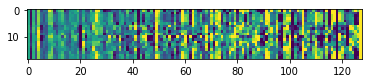

In [77]:
plt.imshow(X_test[0].reshape((19, 128)))

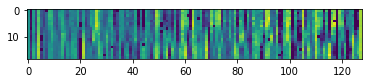

In [32]:
plt.imshow(decoded_imgs[0].reshape((19,128)))

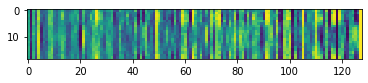

In [81]:
plt.imshow(decoded_imgs[0].reshape((19,128)))

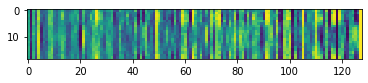

In [83]:
plt.imshow(decoded_imgs[0].reshape((19,128)))

In [ ]:
np.prod(X_train.shape[1:])

# Use the neural network classifier

In [ ]:
model.fit(train_X, train_y_ohe, epochs=100, batch_size=1, verbose=0)

In [ ]:
loss, accuracy = model.evaluate(test_X, test_y_ohe, verbose=0)
print("Accuracy = {:.2f}".format(accuracy))

# BUILD CNN

In [206]:
input_shape = (X_train[0].shape[0], X_train[0].shape[1], 1)

In [207]:
input_shape

(19, 128, 1)

In [154]:
input_feature = Input(shape=(input_shape))

x = Conv2D(4, kernel_size=(3,3), activation='relu', input_shape=input_shape, data_format='channels_last', padding='same')(input_feature)
#x = MaxPooling2D(pool_size=(2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
#x = MaxPooling2D(pool_size=(2,2), padding='same')(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
#x = MaxPooling2D(pool_size=(2,2), padding='same')(x)
#x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
#x = MaxPooling2D(pool_size=(2,2), padding='same', name='pooling')(x)

x = (MaxPooling2D(pool_size=(2,4), padding='same'))(x)
x = (Conv2D(16, (3,3), activation='relu', padding='same'))(x)
x = (MaxPooling2D(pool_size=(2,4), padding='same'))(x)
x = (Conv2D(16, (3,3), activation='relu', padding='same'))(x)
x = (MaxPooling2D(pool_size=(2,2), padding='same', name='pooling'))(x)
encoded = (Conv2D(16, (3,3), activation='relu', padding='same'))(x)
#pooling_shape = tuple(x.shape.as_list()[1:])
#x = (Flatten(name='flatten'))(x)
#x = (Dense(1024, activation='relu'))(x)
#encoded = (Dense(512, activation='relu'))(x)
#x = (Dense(7000, activation='relu'))(x)
#x = (Dense(3500, activation='relu'))(x)
#x = (Dense(1500, activation='relu'))(x)
#encoded = (Dense(512, activation='relu'))(x)
#x = (Dense(1500, activation='relu'))(encoded)
#x = (Dense(3500, activation='relu'))(x)
#x = (Dense(7000, activation='relu'))(x)
#x = (Dense(1024, activation='relu'))(encoded)
#x = (Dense(30000, activation='relu'))(x)

#x = (Dense(np.prod(pooling_shape), activation='relu'))(encoded)
#x = (Reshape((pooling_shape)))(x)

#x = (Conv2D(256, (3,1), activation='relu', padding='same'))(encoded)

x = (UpSampling2D(size=(2,2)))(encoded)
x = (Conv2D(16, (3,3), activation='relu',padding='same'))(x)
x = (UpSampling2D(size=(2,4)))(x)
x = (Conv2D(16, (3,3), activation='relu',padding='same'))(x)
x = (UpSampling2D(size=(2,4)))(x)
x = (Conv2D(16, (3,3), activation='relu',padding='same'))(x)
x = (Conv2D(8, (3,3), activation='relu',padding='same'))(x)
x = (Conv2D(4, (3,3), activation='relu',padding='same'))(x)
decoded = (Conv2D(1, (3,3), activation='sigmoid',padding='same'))(x)
autoencoder = Model(input_feature, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [165]:
input_feature = Input(shape=(input_shape))

x = Conv2D(4, kernel_size=(9,15), activation='relu', input_shape=input_shape, data_format='channels_last')(input_feature)
#x = MaxPooling2D(pool_size=(2,2), padding='same')(x)
x = Conv2D(8, (9,15), activation='relu')(x)
#x = MaxPooling2D(pool_size=(2,2), padding='same')(x)
x = Conv2D(16, (9,15), activation='relu')(x)
#x = MaxPooling2D(pool_size=(2,2), padding='same')(x)
#x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
#x = MaxPooling2D(pool_size=(2,2), padding='same', name='pooling')(x)

#x = (MaxPooling2D(pool_size=(2,4), padding='same'))(x)
x = (Conv2D(16, (8,15), activation='relu'))(x)
x = (Conv2D(16, (1,15), activation='relu'))(x)
x = (Conv2D(16, (1,15), activation='relu'))(x)
encoded = (Conv2D(16, (1,13), activation='relu'))(x)
#encoded = (Conv2D(16, (1,15), activation='relu'))(x)
#x = (Conv2D(16, (1,15), activation='relu'))(x)
#x = (Conv2D(16, (1,15), activation='relu'))(x)
#x = (Conv2D(16, (1,15), activation='relu'))(x)
#x = (Conv2D(16, (1,15), activation='relu'))(x)
#x = (Conv2D(16, (1,15), activation='relu'))(x)
#x = (MaxPooling2D(pool_size=(2,4), padding='same', name='pooling'))(x)
#x = (Conv2D(16, (9,15), activation='relu', padding='same'))(x)

#x = (Conv2D(16, (9,30), activation='relu', padding='same'))(x)


#pooling_shape = tuple(x.shape.as_list()[1:])
#x = (Flatten(name='flatten'))(x)
#x = (Dense(1024, activation='relu'))(x)
#encoded = (Dense(512, activation='relu'))(x)
#x = (Dense(7000, activation='relu'))(x)
#x = (Dense(3500, activation='relu'))(x)
#x = (Dense(1500, activation='relu'))(x)
#encoded = (Dense(512, activation='relu'))(x)
#x = (Dense(1500, activation='relu'))(encoded)
#x = (Dense(3500, activation='relu'))(x)
#x = (Dense(7000, activation='relu'))(x)
#x = (Dense(1024, activation='relu'))(encoded)
#x = (Dense(30000, activation='relu'))(x)

#x = (Dense(np.prod(pooling_shape), activation='relu'))(encoded)
#x = (Reshape((pooling_shape)))(x)

#x = (Conv2D(256, (3,1), activation='relu', padding='same'))(encoded)

x = (UpSampling2D(size=(2,2)))(encoded)
x = (Conv2D(16, (3,3), activation='relu',padding='same'))(x)
x = (UpSampling2D(size=(2,2)))(x)
x = (Conv2D(16, (3,3), activation='relu',padding='same'))(x)
x = (UpSampling2D(size=(2,1)))(x)
x = (Conv2D(8, (3,3), activation='relu',padding='same'))(x)
x = (UpSampling2D(size=(2,1)))(x)
x = (Conv2D(4, (3,3), activation='relu',padding='same'))(x)
x = (UpSampling2D(size=(2,1)))(x)
decoded = (Conv2D(1, (3,3), activation='relu',padding='same'))(x)
autoencoder = Model(input_feature, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [266]:
input_feature = Input(shape=(input_shape))

x = Conv2D(4, kernel_size=(7,15), activation='relu', input_shape=input_shape, data_format='channels_last')(input_feature)
x = BatchNormalization()(x)
x = Conv2D(8, (7,15), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(16, (5,15), activation='relu')(x)
x = BatchNormalization()(x)
x = (Conv2D(16, (3,15), activation='relu'))(x)
x = BatchNormalization()(x)
x = (Conv2D(16, (1,15), activation='relu'))(x)
x = BatchNormalization()(x)
x = (Conv2D(16, (1,15), activation='relu'))(x)
x = BatchNormalization()(x)
encoded = (Conv2D(16, (1,13), activation='relu'))(x)
x = BatchNormalization()(encoded)



x = Conv2DTranspose(16, (1,13), dilation_rate=(1, 1), activation='relu')(x)
x = Conv2DTranspose(16, (1,15), dilation_rate=(1, 1), activation='relu')(x)
x = Conv2DTranspose(16, (1,15), dilation_rate=(1, 1), activation='relu')(x)
x = Conv2DTranspose(16, (3,15), dilation_rate=(1, 1), activation='relu')(x)
x = Conv2DTranspose(8, (5,15), dilation_rate=(1, 1), activation='relu')(x)
x = Conv2DTranspose(4, (7,15), dilation_rate=(1, 1), activation='relu')(x)
decoded = Conv2DTranspose(1, (7,15), dilation_rate=(1, 1), activation='relu')(x)

autoencoder = Model(input_feature, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [239]:
input_shape

(19, 128, 1)

In [256]:
input_feature = Input(shape=(input_shape))
x = (Flatten(name='flatten'))(input_feature)
encoded = (Dense(19*128, activation='relu'))(x)
#x = (Dense(19*128, activation='relu'))(encoded)
decoded = (Reshape((19,128,1)))(encoded)
autoencoder = Model(input_feature, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [177]:
np.prod(tuple(x.shape.as_list()[1:]))

131072

In [178]:
tuple(x.shape.as_list()[1:])

(32, 128, 32)

In [267]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        (None, 19, 128, 1)        0         
_________________________________________________________________
conv2d_566 (Conv2D)          (None, 13, 114, 4)        424       
_________________________________________________________________
batch_normalization_8 (Batch (None, 13, 114, 4)        16        
_________________________________________________________________
conv2d_567 (Conv2D)          (None, 7, 100, 8)         3368      
_________________________________________________________________
batch_normalization_9 (Batch (None, 7, 100, 8)         32        
_________________________________________________________________
conv2d_568 (Conv2D)          (None, 3, 86, 16)         9616      
_________________________________________________________________
batch_normalization_10 (Batc (None, 3, 86, 16)         64        
__________

In [156]:
X_train = np.copy(X_train_padded)
X_test = np.copy(X_test_padded)

In [33]:
X_train = (X_train_padded) / 255
X_test = (X_test_padded) / 255

print(X_train.shape)
print(X_test.shape)

(2100, 32, 128)
(900, 32, 128)


In [215]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))

In [216]:
X_train.shape

(2100, 19, 128, 1)

In [217]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

In [218]:
X_test.shape

(900, 19, 128, 1)

In [38]:
import time
from datetime import datetime


In [47]:
today = datetime.today()

t = today.strftime("%Y%m%d_%H%M%S")

model_folder = f"C:\\Users\\t-anmend\\Documents\\train_1\\models\\best_model_CNN_{t}.ckpt"
model_folder

'C:\\Users\\t-anmend\\Documents\\train_1\\models\\best_model_CNN_20190718_152715.ckpt'

In [268]:
today = datetime.today()

t = today.strftime("%Y%m%d_%H%M%S")

model_folder = f"/home/t-anmend/train1/models/best_model_CNN_{t}.ckpt"
model_folder

'/home/t-anmend/train1/models/best_model_CNN_20190722_141317.ckpt'

In [269]:
checkpoint = ModelCheckpoint(model_folder, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [270]:
tensorboard = TensorBoard(log_dir=f"/home/t-anmend/train1/tensor_board/{t}")

In [271]:
rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-7)

In [272]:
autoencoder.fit(X_train, X_train,
                epochs=1000,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[checkpoint, tensorboard, rate])

Train on 2100 samples, validate on 900 samples
Epoch 1/1000
2100/2100 [==============================] - 6s 3ms/step - loss: 29718.3075 - val_loss: 21893.2312

Epoch 00001: val_loss improved from inf to 21893.23115, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_141317.ckpt
Epoch 2/1000
2100/2100 [==============================] - 4s 2ms/step - loss: 21207.3950 - val_loss: 19349.6671

Epoch 00002: val_loss improved from 21893.23115 to 19349.66708, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_141317.ckpt
Epoch 3/1000
2100/2100 [==============================] - 4s 2ms/step - loss: 17650.7726 - val_loss: 15992.5350

Epoch 00003: val_loss improved from 19349.66708 to 15992.53502, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_141317.ckpt
Epoch 4/1000
2100/2100 [==============================] - 4s 2ms/step - loss: 15031.7636 - val_loss: 16100.6349

Epoch 00004: val_loss did not improve from 15992.53502
Epoch 5/1000
2100/2

2100/2100 [==============================] - 4s 2ms/step - loss: 6804.8392 - val_loss: 6628.9160

Epoch 00039: val_loss improved from 6834.78125 to 6628.91597, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_141317.ckpt
Epoch 40/1000
2100/2100 [==============================] - 4s 2ms/step - loss: 6747.7516 - val_loss: 7046.2556

Epoch 00040: val_loss did not improve from 6628.91597
Epoch 41/1000
2100/2100 [==============================] - 4s 2ms/step - loss: 6673.9549 - val_loss: 6553.9627

Epoch 00041: val_loss improved from 6628.91597 to 6553.96270, saving model to /home/t-anmend/train1/models/best_model_CNN_20190722_141317.ckpt
Epoch 42/1000
2100/2100 [==============================] - 4s 2ms/step - loss: 6639.7194 - val_loss: 6927.7597

Epoch 00042: val_loss did not improve from 6553.96270
Epoch 43/1000
2100/2100 [==============================] - 4s 2ms/step - loss: 6587.5805 - val_loss: 6436.9528

Epoch 00043: val_loss improved from 6553.96270 to 6436.95281

KeyboardInterrupt: 

In [262]:
best_model = load_model(model_folder)

In [226]:
best_model.weights[0].value()

<tf.Tensor 'conv2d_544_1/kernel/read:0' shape=(7, 15, 1, 4) dtype=float32>

In [46]:
encoder = Model(input_img, encoded)

NameError: name 'input_img' is not defined

In [227]:
decoded_imgs = best_model.predict(X_test)
#decoded_imgs = decoded.predict(encoded_imgs)

In [263]:
decoded_imgs = best_model.predict(X_train)

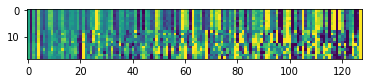

In [234]:
plt.imshow(X_train[0].reshape((19, 128)))

#### No max pooling, middle layer (1, 16, 16)

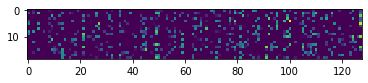

In [264]:
plt.imshow(decoded_imgs[0].reshape((19,128)))

In [114]:
input_shape

(32, 128, 1)

In [146]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,1), activation='relu', input_shape=input_shape, data_format='channels_last', padding='same'))
#model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(64, (3,1), activation='relu', padding='same'))
#model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(128, (3,1), activation='relu', padding='same'))
#model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(256, (3,1), activation='relu', padding='same'))
#model.add(MaxPooling2D(pool_size=(2,2), padding='same', name='pooling'))

#model.add(Conv2D(256, (3,3), activation='relu'))

#model.add(Conv2D(256, (3,3), activation='relu'))

#model.add(Conv2D(256, (3,3), activation='relu'))

#model.add(Conv2D(256, (3,3), activation='relu'))

#model.add(Conv2D(256, (3,3), activation='relu'))

#model.add(Conv2D(256, (3,3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(256, (3,1), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(2,2), padding='same', name='pooling'))

model.add(Conv2D(256, (3,1), activation='relu', padding='same'))

model.add(Flatten(name='flatten'))

model.add(Dense(30000, activation='relu'))

model.add(Dense(15000, activation='relu'))

model.add(Dense(7000, activation='relu'))

model.add(Dense(3500, activation='relu'))

model.add(Dense(1500, activation='relu'))

model.add(Dense(512, activation='relu'))

model.add(Dense(1500, activation='relu'))

model.add(Dense(3500, activation='relu'))

model.add(Dense(7000, activation='relu'))

model.add(Dense(15000, activation='relu'))

model.add(Dense(30000, activation='relu'))

#model.add(Dense(256, activation='relu'))

model.add(Dense(model.get_layer('flatten').output_shape[1], activation='relu'))
model.add(Reshape((model.get_layer('pooling').output_shape[1:])))

model.add(Conv2D(256, (3,1), activation='relu', padding='same'))

model.add(UpSampling2D(size=(2,2)))
#model.add(UpSampling2D(size=(1,1)))
model.add(Conv2D(256, (3,1), activation='relu',padding='same'))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(128, (3,1), activation='relu',padding='same'))
model.add(Conv2D(64, (3,1), activation='relu',padding='same'))
#model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(32, (3,1), activation='relu',padding='same'))
#model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(1, (3,1), activation='sigmoid',padding='same'))
model.compile(loss='binary_crossentropy', optimizer='adadelta')

In [82]:
model.get_layer('flatten').output_shape[1]

4096

In [83]:
model.get_layer('pooling').output_shape[1:]

(2, 8, 256)

In [147]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_250 (Conv2D)          (None, 32, 128, 32)       128       
_________________________________________________________________
conv2d_251 (Conv2D)          (None, 32, 128, 64)       6208      
_________________________________________________________________
conv2d_252 (Conv2D)          (None, 32, 128, 128)      24704     
_________________________________________________________________
conv2d_253 (Conv2D)          (None, 32, 128, 256)      98560     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 16, 64, 256)       0         
_________________________________________________________________
conv2d_254 (Conv2D)          (None, 16, 64, 256)       196864    
_________________________________________________________________
pooling (MaxPooling2D)       (None, 8, 32, 256)        0         
__________

In [81]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(4,1), activation='relu', input_shape=input_shape, data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(64, (4,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(128, (3,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adadelta')

In [82]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 16, 128, 32)       160       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 64, 32)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 5, 64, 64)         8256      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 32, 64)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 1, 32, 128)        24704     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 16, 128)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
__________